In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import (
    make_column_transformer,
    make_column_selector,
    ColumnTransformer,
)

from sklearn.metrics import classification_report

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn import set_config

set_config(display="diagram")

#### Auxiliary variables

In [3]:
filename_input = "data-hdma-eastbay-2019-2022-processed"
filename_output = "data-hdma-eastbay-2019-2022-sklearn"

#### Loading the processed data

In [4]:
df = pd.read_csv(f"../../{filename_input}.csv", index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219267 entries, 34 to 544843
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   debt_to_income_ratio_df            219267 non-null  float64
 1   property_value                     219267 non-null  float64
 2   loan_term                          219267 non-null  float64
 3   loan_to_value_ratio                219267 non-null  float64
 4   loan_amount                        219267 non-null  float64
 5   income                             219267 non-null  float64
 6   tract_minority_population_percent  219267 non-null  float64
 7   tract_to_msa_income_percentage     219267 non-null  float64
 8   tract_population                   219267 non-null  float64
 9   tract_one_to_four_family_homes     219267 non-null  float64
 10  tract_median_age_of_housing_units  219267 non-null  float64
 11  tract_owner_occupied_units         219267 n

## 3. Preparing for modeling

### 3.1. Lists of feature names

In [8]:
df["sqrt_income"] = df["income"].apply(np.sqrt)
df["sqrt_property_value"] = df["property_value"].apply(np.sqrt)
df["sqrt_loan_amount"] = df["loan_amount"].apply(np.sqrt)

tract_features = [x for x in df.columns if x.startswith("tract_")]

numerical_loan_features = [
    "debt_to_income_ratio",
    # "debt_to_income_ratio_df",
    # "loan_term",
    "loan_to_value_ratio",
]
numerical_currency_features = ["property_value", "income", "loan_amount"]
numerical_sqrt_currency_features = [
    "sqrt_income",
    "sqrt_property_value",
    "sqrt_loan_amount",
]
categorical_applicant_features = [
    "applicant_sex",
    "applicant_race",
    "applicant_ethnicity",
    "applicant_age",
]
categorical_coapplicant_features = [
    "coapplicant_sex",
    "coapplicant_race",
    "coapplicant_ethnicity",
    "coapplicant_age",
]
categorical_loan_features = [
    # "conforming_loan_limit",
    "occupancy_type",
    # "hoepa_status",
    # "lien_status",
    "loan_purpose",
    "loan_type",
]
binary_features = [
    "applicant_age_above_62",
    "interest_only_payment",
    "business_or_commercial_purpose",
    "open-end_line_of_credit",
]

derived_features = [
    "derived_sex",
    "derived_race",
    "derived_ethnicity",
    "derived_loan_product_type",
]

target_related_features = ["denial_reason"]

target_feature = "application_outcome"

### 3.3. X,y

In [83]:
X = df[
    numerical_loan_features
    + numerical_currency_features
    + numerical_sqrt_currency_features
    # + categorical_applicant_features
    # + categorical_coapplicant_features
    + categorical_loan_features
    # + binary_features
    # + derived_features
]
y = df[target_feature].map({'Approved': 1, 'Denied': 0})

categorical_columns = X.select_dtypes(include=object).columns
numerical_columns = X.select_dtypes(include=float).columns

print(categorical_columns)
print(numerical_columns)

X.loc[:, categorical_columns] = X.loc[:, categorical_columns].astype('category')

Index(['occupancy_type', 'loan_purpose', 'loan_type'], dtype='object')
Index(['debt_to_income_ratio', 'loan_to_value_ratio', 'property_value',
       'income', 'loan_amount', 'sqrt_income', 'sqrt_property_value',
       'sqrt_loan_amount'],
      dtype='object')


In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219267 entries, 34 to 544843
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   debt_to_income_ratio  219267 non-null  float64
 1   loan_to_value_ratio   219267 non-null  float64
 2   property_value        219267 non-null  float64
 3   income                219267 non-null  float64
 4   loan_amount           219267 non-null  float64
 5   sqrt_income           219267 non-null  float64
 6   sqrt_property_value   219267 non-null  float64
 7   sqrt_loan_amount      219267 non-null  float64
 8   occupancy_type        219267 non-null  object 
 9   loan_purpose          219267 non-null  object 
 10  loan_type             219267 non-null  object 
dtypes: float64(8), object(3)
memory usage: 20.1+ MB


In [85]:
def main_column_transformer():
    return ColumnTransformer(
        [
            # ("ohe", OneHotEncoder(sparse_output=False), categorical_columns),
            ("scaler", StandardScaler(), numerical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )

def total_column_transformer():
    return ColumnTransformer(
        [
            ("ohe", OneHotEncoder(sparse_output=False), categorical_columns),
            ("scaler", StandardScaler(), numerical_columns),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    
preprocessor = main_column_transformer().set_output(transform="pandas")
X_scaled = preprocessor.fit_transform(X)

total_preprocessor = total_column_transformer().set_output(transform="pandas")
X_transformed = total_preprocessor.fit_transform(X)

In [86]:
X_scaled.head()

,debt_to_income_ratio,loan_to_value_ratio,property_value,income,loan_amount,sqrt_income,sqrt_property_value,sqrt_loan_amount,occupancy_type,loan_purpose,loan_type
34,0.227794,1.645800,-1.455915,-0.628359,-0.583788,-0.598563,-1.867043,-0.454934,Main residence,Home purchase,Conventional
38,0.376610,0.395461,-1.299258,-1.029446,-0.634270,-1.221980,-1.580328,-0.520262,Investment property,Cash-out refinancing,Conventional
48,1.195100,1.370716,-0.359316,-0.450098,0.829683,-0.365160,-0.277902,0.903926,Main residence,Home purchase,FHA
53,-1.037145,0.026189,-0.933725,0.136678,-0.381864,0.294694,-1.010008,-0.211841,Main residence,Refinancing,Conventional
54,1.195100,-0.832952,-0.603005,-0.873467,-0.457586,-0.958837,-0.570414,-0.299914,Main residence,Cash-out refinancing,VA


### 3.4. train/test split

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X_transformed, y, test_size=0.3, stratify=y, random_state=42
)

In [88]:
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219267 entries, 34 to 544843
Data columns (total 19 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   occupancy_type_Investment property  219267 non-null  float64
 1   occupancy_type_Main residence       219267 non-null  float64
 2   occupancy_type_Second residence     219267 non-null  float64
 3   loan_purpose_Cash-out refinancing   219267 non-null  float64
 4   loan_purpose_Home improvement       219267 non-null  float64
 5   loan_purpose_Home purchase          219267 non-null  float64
 6   loan_purpose_Other                  219267 non-null  float64
 7   loan_purpose_Refinancing            219267 non-null  float64
 8   loan_type_Conventional              219267 non-null  float64
 9   loan_type_FHA                       219267 non-null  float64
 10  loan_type_VA                        219267 non-null  float64
 11  debt_to_income_ratio          

## 4. Modeling

In [73]:
model = HistGradientBoostingClassifier(
    categorical_features=categorical_columns,
    validation_fraction=0.3,
    verbose=4,
    class_weight="balanced",
    max_iter=1000,
    max_leaf_nodes=31,
    early_stopping=True,
    scoring='precision',
    l2_regularization=0.1,
    n_iter_no_change=50,
    learning_rate=0.1,
    max_depth=8,
)
model.fit(X_scaled, y)

Binning 0.014 GB of training data: 0.156 s
Binning 0.006 GB of validation data: 0.011 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.71233, val score: 0.70671, in 0.076s
[2/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.71776, val score: 0.71321, in 0.055s
[3/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.71818, val score: 0.71440, in 0.070s
[4/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.71963, val score: 0.71482, in 0.065s
[5/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.72031, val score: 0.71667, in 0.043s
[6/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.72005, val score: 0.71321, in 0.054s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.72051, val score: 0.71459, in 0.067s
[8/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.72196, val score: 0.71612, in 0.068s
[9/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.72317, val score: 0.71703, in 0.044s
[10/1000] 1 tree, 31 lea

HistGradientBoostingClassifier(categorical_features=Index(['occupancy_type', 'loan_purpose', 'loan_type'], dtype='object'),
                               class_weight='balanced', early_stopping=True,
                               l2_regularization=0.1, max_depth=8,
                               max_iter=1000, n_iter_no_change=50,
                               scoring='precision', validation_fraction=0.3,
                               verbose=4)

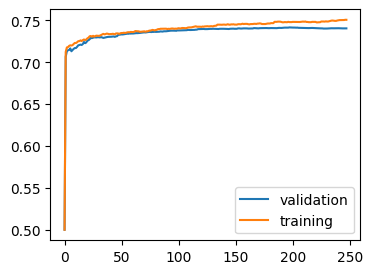

In [74]:
plt.figure(figsize=(4,3))
plt.plot(model.validation_score_, label='validation')
plt.plot(model.train_score_, label='training')
plt.legend()
plt.show()

In [75]:
model.n_iter_

247

In [78]:
model.train_score_.max()

0.7508214934660812

In [79]:
model.validation_score_.max()

0.7417157554953148

In [76]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.73      0.71     22501
           1       0.86      0.84      0.85     43280

    accuracy                           0.80     65781
   macro avg       0.78      0.78      0.78     65781
weighted avg       0.80      0.80      0.80     65781



## AdaBoost

In [89]:
from sklearn.ensemble import AdaBoostClassifier

In [94]:
model_adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1).fit(X_train_total, y_train_total)

/home/henrique/mlai-course/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [95]:
model_adaboost.score(X_test_total, y_test_total)

0.7880543013940196

In [97]:
model_adaboost.score(X_train_total, y_train_total)

0.7849575857081428

In [96]:
print(classification_report(y_test_total, model_adaboost.predict(X_test_total)))

              precision    recall  f1-score   support

           0       0.85      0.46      0.60     22501
           1       0.77      0.96      0.86     43280

    accuracy                           0.79     65781
   macro avg       0.81      0.71      0.73     65781
weighted avg       0.80      0.79      0.77     65781

